In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    roc_curve,
    auc,
    confusion_matrix,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns

from module.dl_data import load_set_dataloader
from module.dl_train import fit

1. 데이터 로드 및 전처리:    
데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.

2. 모델 정의:    
드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.    
ReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.

3. 옵티마이저 및 스케줄러 설정:    
Adam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.    
CosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.

4. 학습 과정:    
optimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.     
매 에포크마다 학습 손실과 정확도를 기록합니다.    
scheduler.step()을 통해 매 epoch마다 학습률을 조정하여 과적합 방지

In [ ]:
%%writefile module/dl_data.py
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드 및 전처리 함수
def load_set_dataloader(file_path, batch_size):
    # 데이터 로드
    data = pd.read_csv(file_path)

    # 입력 데이터(X)와 타겟(y) 분리
    X = data.drop(["ID", "label"], axis=1)
    y = np.array(data["label"])
    y = y.reshape(-1, 1)

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=0
    )

    # 데이터 표준화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # PyTorch 텐서로 변환 후 TensorDataset과 DataLoader 생성 (배치 학습 적용)
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2860)

    return train_loader, test_loader, y_test

In [2]:
# 데이터 로드 및 분리 - 이상치 제거 X
train_loader, test_loader, y_test = load_set_dataloader("data/preprocessed.csv", 64)

In [ ]:
# 데이터 로드 및 분리 - 이상치 제거
train_loader, test_loader, y_test = load_set_dataloader(
    "data/preprocessed_drives_outlier.csv", 64
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 모델
class ChurnPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 은닉층과 배치 정규화, 드롭아웃 추가
        self.fc1 = nn.Linear(12, 128)  # 첫 번째 은닉층
        self.bn1 = nn.BatchNorm1d(128)  # 첫 번째 배치 정규화
        self.fc2 = nn.Linear(128, 64)  # 두 번째 은닉층
        self.bn2 = nn.BatchNorm1d(64)  # 두 번째 배치 정규화
        self.fc3 = nn.Linear(64, 32)  # 세 번째 은닉층
        self.bn3 = nn.BatchNorm1d(32)  # 세 번째 배치 정규화
        self.fc4 = nn.Linear(32, 1)  # 출력층

        # 활성화 함수와 드롭아웃 설정
        self.relu = nn.ReLU()  # 활성화 함수
        self.dropout = nn.Dropout(0.35)  # 드롭아웃 확률: 35%

    def forward(self, x):
        # 각 은닉층 통과 시 배치 정규화 및 드롭아웃 적용
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # 이진 분류를 위한 sigmoid 활성화 함수
        return x

In [5]:
# 모델, 손실 함수, 옵티마이저 및 학습률 스케줄러 정의
model = ChurnPredictionModel()
loss_fn = nn.BCELoss()  # 이진 분류에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

num_epochs = 100
patience = 20  # 조기 종료를 위한 patience 값

In [6]:
# 이상치 제거 X
save_path = "model/dl_model.pth"  # 최적 모델 저장 경로

In [ ]:
# 이상치 제거
save_path = "model/dl_model_outlier.pth"  # 최적 모델 저장 경로

In [ ]:
%%writefile module/dl_train.py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import time

# train 함수에 들어가는 valid 부분
def valid(dataloader, model, loss_fn, device="cpu"):
    model.to(device)
    model.eval()
    loss = acc = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)  # positive일 확률
            loss += loss_fn(pred, y).item()
            #  이진 분류에서 accuracy
            acc += torch.sum((pred > 0.5).type(torch.int32) == y).item()
        loss /= len(dataloader)
        acc /= len(dataloader.dataset)
    return loss, acc

def train(dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    train_loss = 0
    # 학습률 조정 스케줄러: CosineAnnealingWarmRestarts를 사용하여 학습률을 주기적으로 리셋
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # 손실 계산 및 역전파
        loss = loss_fn(pred, y)
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 파라미터 초기화
        optimizer.zero_grad()
        train_loss += loss.item()
    # LR 변경 요청
    scheduler.step()
    # loss 계산 및 list 추가
    train_loss /= len(dataloader)
    return train_loss

# 학습
def fit(num_epochs, train_loader, valid_loader, model, loss_fn, optimizer, save_path, patience, device="cpu"):
    # 손실과 정확도 기록용 리스트 초기화
    train_losses = []
    valid_losses = []
    valid_acces = []
    best_score = torch.inf  # 성능 개선 기준 초기값
    trigger_count = 0  # 개선이 없을 때 증가하는 카운트

    s = time.time()  # 학습 시작 시간 기록
    for epoch in range(num_epochs):
        # 모델 학습
        train_loss = train(train_loader, model, loss_fn, optimizer)
        # 모델 검증
        valid_loss, valid_acc = valid(valid_loader, model, loss_fn)
        
        # loss 계산 및 list 추가
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)

        # Best Score 업데이트 및 조기 종료 체크
        if valid_loss < best_score:
            print(
                f"Epoch [{epoch+1:3d}/{num_epochs}], >>>>> Loss Improved from {best_score:.4f} to {valid_loss:.4f}. Saving Model."
            )
            best_score = valid_loss
            torch.save(model, save_path)
            trigger_count = 0  # 성능 개선 시 초기화
        else:
            trigger_count += 1
            if trigger_count >= patience:
                print(
                    f"Early stopping at epoch {epoch+1:3d}. No improvement for {patience} epochs."
                )
                break

        print(
            f"Epoch [{epoch+1:3d}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
        )

    e = time.time()
    training_time = e - s
    print(f"\nTotal Training Time: {training_time:.2f} seconds")
    return train_losses, valid_losses, valid_acces

In [7]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4275. Saving Model.
Epoch [  1/100], Train Loss: 0.5001, Valid Loss: 0.4275, Valid Acc: 0.8224
Epoch [  2/100], >>>>> Loss Improved from 0.4275 to 0.4186. Saving Model.
Epoch [  2/100], Train Loss: 0.4309, Valid Loss: 0.4186, Valid Acc: 0.8224
Epoch [  3/100], >>>>> Loss Improved from 0.4186 to 0.4175. Saving Model.
Epoch [  3/100], Train Loss: 0.4236, Valid Loss: 0.4175, Valid Acc: 0.8224
Epoch [  4/100], >>>>> Loss Improved from 0.4175 to 0.4162. Saving Model.
Epoch [  4/100], Train Loss: 0.4212, Valid Loss: 0.4162, Valid Acc: 0.8234
Epoch [  5/100], Train Loss: 0.4190, Valid Loss: 0.4179, Valid Acc: 0.8227
Epoch [  6/100], Train Loss: 0.4146, Valid Loss: 0.4172, Valid Acc: 0.8231
Epoch [  7/100], Train Loss: 0.4180, Valid Loss: 0.4163, Valid Acc: 0.8227
Epoch [  8/100], >>>>> Loss Improved from 0.4162 to 0.4161. Saving Model.
Epoch [  8/100], Train Loss: 0.4130, Valid Loss: 0.4161, Valid Acc: 0.8227
Epoch [  9/100], >>>>> Loss Impro

In [8]:
# load best model
best_model = torch.load(save_path, weights_only=False)
best_model.eval()

# 모델 평가
y_pred_list = []
y_prob_list = []
valid_acc = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        prob_test = model(X_batch)
        pred_test = prob_test.round()
        valid_acc += torch.sum((pred_test < 0.5).type(torch.int32) == y_batch).item()
        y_pred_list.append(pred_test)
        y_prob_list.append(prob_test)
    y_pred_list = np.concatenate(y_pred_list)
    y_prob_list = np.concatenate(y_prob_list)

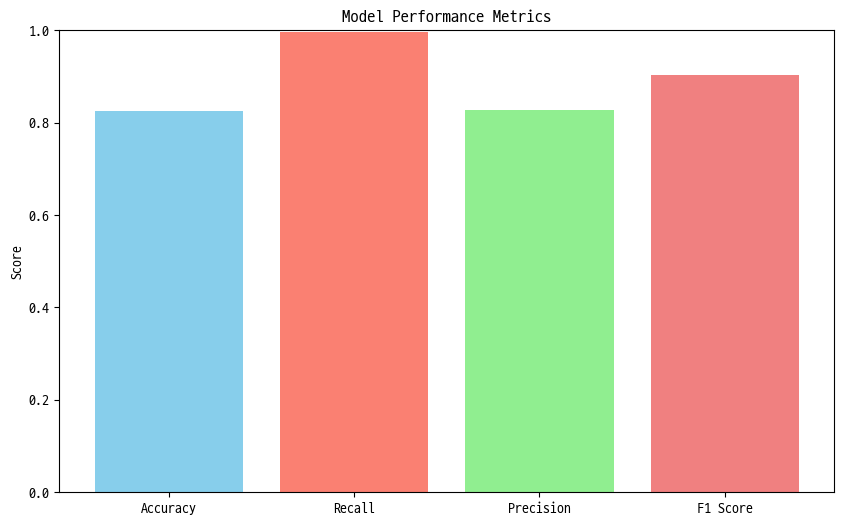

In [9]:
# 성능 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred_list)
recall = recall_score(y_test, y_pred_list)
precision = precision_score(y_test, y_pred_list)
f1 = f1_score(y_test, y_pred_list)

# 정확도, 재현율, 정밀도, F1 점수 시각화
metrics = ["Accuracy", "Recall", "Precision", "F1 Score"]
values = [accuracy, recall, precision, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=["skyblue", "salmon", "lightgreen", "lightcoral"])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

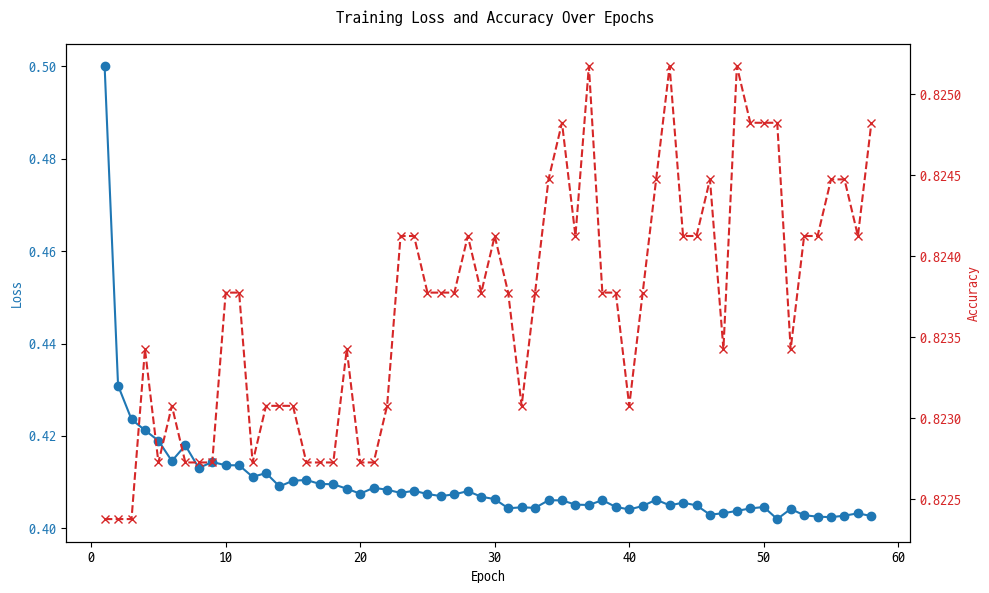

In [10]:
# 이중 y축 그래프: 학습 손실 및 정확도 변화 추세
fig, ax1 = plt.subplots(figsize=(10, 6))

# 손실 값 (왼쪽 y축)
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(
    range(1, len(train_losses) + 1),
    train_losses,
    color=color,
    marker="o",
    label="Train Loss",
)
ax1.tick_params(axis="y", labelcolor=color)

# 정확도 값 (오른쪽 y축)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(
    range(1, len(valid_acces) + 1),
    valid_acces,
    color=color,
    marker="x",
    linestyle="--",
    label="valid Accuracy",
)
ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle("Training Loss and Accuracy Over Epochs")
fig.tight_layout()
plt.show()

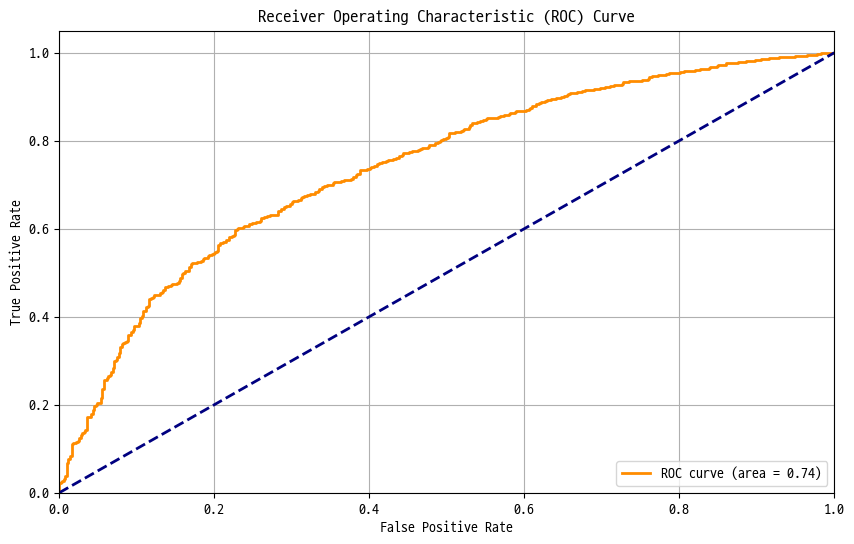

In [11]:
# ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob_list)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

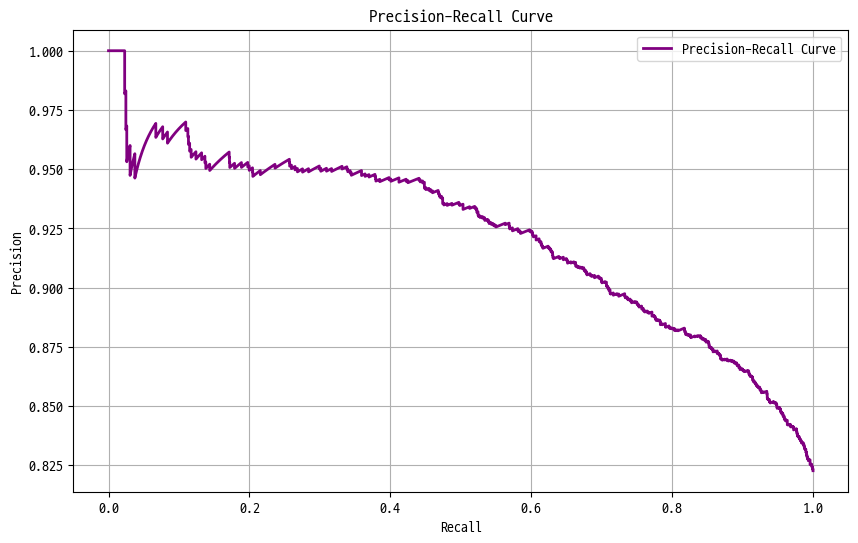

In [12]:
# Precision-Recall 곡선
precision, recall, _ = precision_recall_curve(y_test, y_prob_list)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color="purple", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

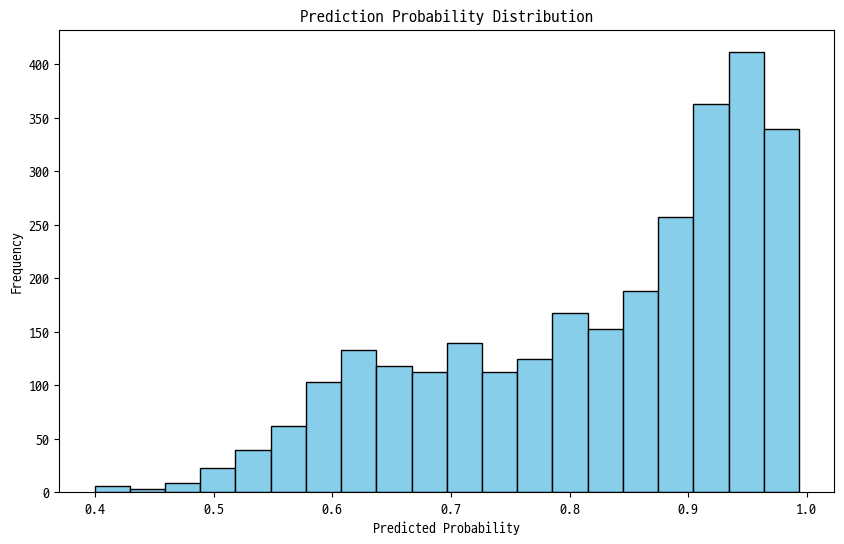

In [13]:
# 예측 확률 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(y_prob_list, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Prediction Probability Distribution")
plt.show()

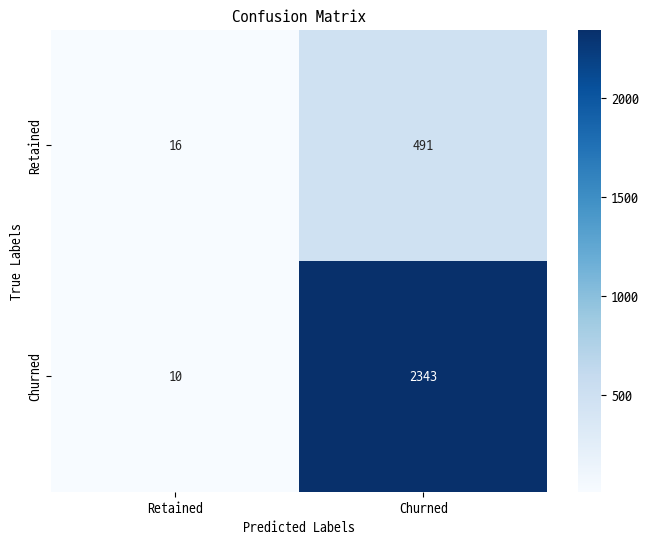

In [14]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_list)

# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Retained", "Churned"],
    yticklabels=["Retained", "Churned"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()